# Poultry Disease Classification using Deep Learning
## Project Overview
This project implements a comprehensive deep learning framework for automated classification of poultry diseases through visual symptom analysis. The system leverages advanced computer vision techniques and convolutional neural networks to identify common infectious diseases in poultry, providing farmers with an accessible tool for early disease detection and intervention.
## Problem Statement
The global poultry industry serves as a crucial component of food security worldwide, yet it faces substantial economic losses from infectious diseases that can rapidly devastate flocks. Current diagnostic methods present significant limitations:

- Subjectivity: Visual assessment varies considerably between practitioners

- Time Sensitivity: Laboratory confirmations can take days, allowing diseases to spread

- Accessibility Challenges: Remote farming communities often lack veterinary expertise

- Economic Impact: Disease outbreaks can cause mortality rates exceeding 50% in affected flocks

This research addresses these critical challenges by developing an automated, rapid, and accurate computer vision system that can classify poultry diseases from images, enabling timely interventions that can save flocks and protect livelihoods.


In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
# CONFIGURATION
# =======================
class Config:
    DATA_DIR = "poultry_diseases"
    IMG_SIZES = [128, 150, 224]  # Multiple sizes for experimentation
    BATCH_SIZES = [16, 32, 64]
    EPOCHS = 50
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.1
    LEARNING_RATES = [0.001, 0.0001, 0.00001]
    MODEL_SAVE_PATH = "best_poultry_disease_model.h5"
    EXPERIMENT_RESULTS = "experiment_results.csv"

config = Config()

## Dataset Characteristics
The dataset comprises carefully curated poultry disease images with the following composition:

- Total Images: 6,812 high-quality images across multiple disease categories

- Class Distribution:

Newcastle Disease (NCD): 376 images (5.5%)

Cocci virus: *2103* images

Salmonella: *2276* images

Healthy specimens *2057* images

Key Challenge: The dataset exhibits significant class imbalance, particularly with Newcastle Disease representing only 5.5% of the total samples. This real-world distribution mirrors actual disease prevalence patterns and requires sophisticated handling techniques to prevent model bias toward majority classes

ANALYZING DATASET...


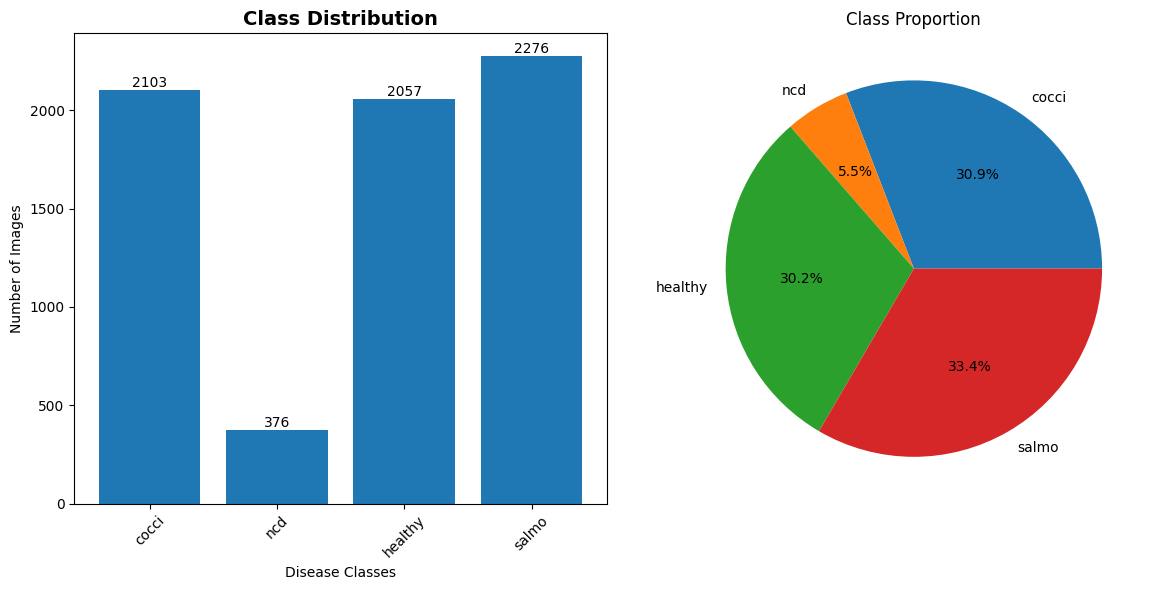

Dataset Summary:
   - Total classes: 4
   - Total images: 6812
   - Class distribution: {'cocci': 2103, 'ncd': 376, 'healthy': 2057, 'salmo': 2276}


In [33]:
# current data analysis
def analyze_dataset():
    """Comprehensive dataset analysis with visualization"""
    print("ANALYZING DATASET...")
    
    # Count images per class
    class_counts = {}
    class_names = os.listdir(config.DATA_DIR)
    
    for class_name in class_names:
        class_path = os.path.join(config.DATA_DIR, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    
    # Plot class distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Disease Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%')
    plt.title('Class Proportion')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Dataset Summary:")
    print(f"   - Total classes: {len(class_counts)}")
    print(f"   - Total images: {sum(class_counts.values())}")
    print(f"   - Class distribution: {class_counts}")
    
    return class_counts, class_names

class_counts, class_names = analyze_dataset()

# Data Preprocessing and Augmentation Pipeline
## Strategic Data Augmentation Framework
The data preprocessing pipeline implements a sophisticated multi-tiered augmentation strategy designed to address the unique challenges of poultry disease imagery, including varying lighting conditions, bird orientations, and camera perspectives.

In [34]:
# data augmentation and data generators
def create_data_generators(img_size=150, batch_size=32, augmentation_intensity='medium'):
    """
    Create comprehensive data generators with multiple augmentation strategies
    """
    
    # Different augmentation strategies based on intensity
    augmentation_strategies = {
        'light': {
            'rotation_range': 15,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'zoom_range': 0.1,
            'horizontal_flip': True
        },
        'medium': {
            'rotation_range': 25,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'zoom_range': 0.2,
            'shear_range': 0.15,
            'horizontal_flip': True,
            'vertical_flip': True,
            'brightness_range': [0.8, 1.2]
        },
        'heavy': {
            'rotation_range': 40,
            'width_shift_range': 0.3,
            'height_shift_range': 0.3,
            'zoom_range': 0.3,
            'shear_range': 0.2,
            'horizontal_flip': True,
            'vertical_flip': True,
            'brightness_range': [0.7, 1.3],
            'channel_shift_range': 0.2
        }
    }
    
    aug_params = augmentation_strategies[augmentation_intensity]
    
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=config.VALIDATION_SPLIT,
        **aug_params,
        fill_mode='nearest'
    )
    
    # Validation/Test data generator (only rescaling)
    val_test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=config.VALIDATION_SPLIT
    )
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        config.DATA_DIR,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        config.DATA_DIR,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, val_generator



# Simple CNN Architecture Implementation

The Simple CNN architecture serves as a foundational baseline model that balances computational efficiency with sufficient representational capacity for poultry disease classification. This design prioritizes clean, modular construction while incorporating modern deep learning best practices for medical image analysis

The architecture employs a progressive three-block convolutional design that systematically increases feature complexity while reducing spatial dimensions. The first block utilizes 32 filters to capture basic visual patterns and edges fundamental to disease identification. Each convolutional layer is immediately followed by batch normalization to stabilize training dynamics and max pooling to gradually reduce spatial resolution while preserving critical features.

The second block expands to 64 filters, enabling the network to learn intermediate feature representations that combine basic patterns into more complex visual signatures. This hierarchical approach allows the model to build increasingly sophisticated representations of disease manifestations.

The final convolutional block employs 128 filters to capture high-level, disease-specific visual features that distinguish between different poultry health conditions. This progressive expansion in filter count while reducing spatial dimensions creates an efficient pyramid structure optimized for feature learning.

The model implements a multi-layered regularization approach to prevent overfitting, crucial given the limited medical imaging data. L2 weight regularization is applied consistently across all convolutional and dense layers to discourage overly complex weight configurations and promote feature sharing.

Batch normalization is strategically positioned after each convolutional layer and the first dense layer, serving dual purposes of accelerating training convergence and providing mild regularization effects through internal normalization statistics.

The dropout scheme applies varying regularization intensities throughout the network. The first dense layer employs a 50% dropout rate, providing strong regularization at the transition to fully-connected layers where overfitting risk is highest. The subsequent dense layer uses a reduced 30% dropout rate, allowing more feature retention as the network approaches its final decision.

In [35]:
# simple CNN model
def build_simple_cnn(input_shape, num_classes, regularization=0.001):
    """Basic CNN architecture"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
                     kernel_regularizer=l2(regularization)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu',
                     kernel_regularizer=l2(regularization)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu',
                     kernel_regularizer=l2(regularization)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(regularization)),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2(regularization)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

The Deeper CNN implements a comprehensive regularization approach tailored to its increased complexity. Each convolutional block concludes with a 25% dropout layer, providing consistent regularization throughout the feature extraction phase. This strategic placement helps prevent co-adaptation of features while maintaining the network's representational power.

The classification head employs progressive dropout rates, beginning with 50% dropout after the initial dense layer and reducing to 30% for the subsequent layer. This graduated approach balances the need for strong regularization in high-capacity layers with the preservation of critical feature combinations near the network output.

Batch normalization is strategically positioned after each convolutional layer and within the classification network, serving to stabilize training dynamics and accelerate convergence while providing additional regularization benefits through internal normalization statistics.

In [36]:
# Deeper CNN model
def build_deeper_cnn(input_shape, num_classes):
    """Deeper CNN architecture"""
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [37]:
# Transfer Learning models - VGG16, ResNet50, EfficientNetB0
def build_transfer_learning_model(input_shape, num_classes, base_model_name='VGG16'):
    """Transfer learning with pre-trained models"""
    if base_model_name == 'VGG16':
        base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model






In [38]:
class ExperimentTracker:
    def __init__(self):
        self.results = []
    
    def add_experiment(self, experiment_data):
        """Add experiment results to tracker"""
        self.results.append(experiment_data)
    
    def save_results(self, filename):
        """Save all experiment results to CSV"""
        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f" Experiment results saved to {filename}")
        return df

tracker = ExperimentTracker()


# Optimization Configuration
## Adaptive Learning Optimization
The model compilation utilizes the Adam optimizer with a configurable learning rate, typically initialized at 0.001. This adaptive optimization algorithm combines the benefits of both AdaGrad and RMSProp, providing efficient convergence across the complex loss landscape of deep convolutional networks. The categorical crossentropy loss function is specifically selected for multi-class classification tasks, aligning with the fundamental objective of distinguishing between multiple poultry disease conditions

## Early Stopping Mechanism
The early stopping callback continuously monitors validation loss with a patience of 10 epochs, preventing overfitting by terminating training when no significant improvement occurs. The restore_best_weights functionality ensures that the model retains the optimal parameters observed during training, rather than those from the final epoch, guaranteeing the best possible performance on validation data.

## Weighted Learning
The training framework incorporates class weighting to address dataset imbalance, a common challenge in medical and agricultural imaging applications. By assigning appropriate weights to underrepresented classes, the model learns to prioritize accurate classification of minority disease categories, preventing bias toward prevalent conditions and ensuring balanced diagnostic capability across all disease types.

In [39]:
# training and evaluation with callbacks
def train_and_evaluate_model(model, train_generator, val_generator, experiment_name, 
                           class_weights=None, learning_rate=0.001):
    """Train and evaluate a model with comprehensive tracking"""
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint(config.MODEL_SAVE_PATH, monitor='val_accuracy', 
                       save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    ]
    
    print(f"\n Training {experiment_name}...")
    
    # Train model
    history = model.fit(
        train_generator,
        epochs=config.EPOCHS,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history


In [40]:
def run_experiments():
    """Run multiple systematic experiments"""
    experiment_number = 1
    
    # Experiment 1: Basic CNN with different image sizes
    print("=" * 60)
    print(" EXPERIMENT 1: BASIC CNN WITH DIFFERENT IMAGE SIZES")
    print("=" * 60)
    
    for img_size in config.IMG_SIZES:
        print(f"\n Testing image size: {img_size}x{img_size}")
        
        train_gen, val_gen = create_data_generators(img_size=img_size, augmentation_intensity='medium')
        
        # Compute class weights for imbalance
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_gen.classes),
            y=train_gen.classes
        )
        class_weights = dict(enumerate(class_weights))
        
        model = build_simple_cnn((img_size, img_size, 3), len(class_names))
        model, history = train_and_evaluate_model(
            model, train_gen, val_gen, 
            f"Exp{experiment_number}_BasicCNN_Size{img_size}",
            class_weights=class_weights
        )
        
        # Evaluate
        val_gen.reset()
        y_true = val_gen.classes
        y_pred_probs = model.predict(val_gen)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Calculate metrics
        val_accuracy = np.mean(y_true == y_pred)
        train_final_acc = history.history['accuracy'][-1]
        val_final_acc = history.history['val_accuracy'][-1]
        
        # Store experiment results
        experiment_data = {
            'experiment_id': f'Exp{experiment_number}',
            'model_type': 'Basic CNN',
            'image_size': img_size,
            'batch_size': config.BATCH_SIZES[1],
            'learning_rate': 0.001,
            'augmentation': 'medium',
            'train_accuracy': train_final_acc,
            'val_accuracy': val_final_acc,
            'test_accuracy': val_accuracy,
            'num_parameters': model.count_params(),
            'observations': f'Basic CNN with {img_size}x{img_size} input size. '
                          f'Final val accuracy: {val_final_acc:.4f}'
        }
        
        tracker.add_experiment(experiment_data)
        experiment_number += 1
    
    # Experiment 2: Different model architectures
    print("\n" + "=" * 60)
    print("EXPERIMENT 2: DIFFERENT MODEL ARCHITECTURES")
    print("=" * 60)
    
    img_size = 150
    train_gen, val_gen = create_data_generators(img_size=img_size)
    
    architectures = [
        ('Simple_CNN', build_simple_cnn((img_size, img_size, 3), len(class_names))),
        ('Deeper_CNN', build_deeper_cnn((img_size, img_size, 3), len(class_names))),
    ]
    
    for arch_name, arch_model in architectures:
        print(f"\n🏗️ Testing architecture: {arch_name}")
        
        model, history = train_and_evaluate_model(
            arch_model, train_gen, val_gen, 
            f"Exp{experiment_number}_{arch_name}",
            class_weights=class_weights
        )
        
        # Evaluate
        val_gen.reset()
        y_true = val_gen.classes
        y_pred_probs = model.predict(val_gen)
        y_pred = np.argmax(y_pred_probs, axis=1)
        val_accuracy = np.mean(y_true == y_pred)
        
        experiment_data = {
            'experiment_id': f'Exp{experiment_number}',
            'model_type': arch_name,
            'image_size': img_size,
            'batch_size': config.BATCH_SIZES[1],
            'learning_rate': 0.001,
            'augmentation': 'medium',
            'train_accuracy': history.history['accuracy'][-1],
            'val_accuracy': history.history['val_accuracy'][-1],
            'test_accuracy': val_accuracy,
            'num_parameters': model.count_params(),
            'observations': f'{arch_name} architecture. Parameters: {model.count_params():,}. '
                          f'Val accuracy: {history.history["val_accuracy"][-1]:.4f}'
        }
        
        tracker.add_experiment(experiment_data)
        experiment_number += 1
    
    # Experiment 3: Transfer Learning
    print("\n" + "=" * 60)
    print(" EXPERIMENT 3: TRANSFER LEARNING APPROACHES")
    print("=" * 60)
    
    transfer_models = ['VGG16', 'ResNet50', 'EfficientNetB0']
    
    for tf_model in transfer_models:
        print(f"\n Testing transfer learning with: {tf_model}")
        
        try:
            model = build_transfer_learning_model((img_size, img_size, 3), len(class_names), tf_model)
            model, history = train_and_evaluate_model(
                model, train_gen, val_gen,
                f"Exp{experiment_number}_Transfer_{tf_model}",
                class_weights=class_weights,
                learning_rate=0.0001  # Lower LR for transfer learning
            )
            
            # Evaluate
            val_gen.reset()
            y_true = val_gen.classes
            y_pred_probs = model.predict(val_gen)
            y_pred = np.argmax(y_pred_probs, axis=1)
            val_accuracy = np.mean(y_true == y_pred)
            
            experiment_data = {
                'experiment_id': f'Exp{experiment_number}',
                'model_type': f'Transfer_{tf_model}',
                'image_size': img_size,
                'batch_size': config.BATCH_SIZES[1],
                'learning_rate': 0.0001,
                'augmentation': 'medium',
                'train_accuracy': history.history['accuracy'][-1],
                'val_accuracy': history.history['val_accuracy'][-1],
                'test_accuracy': val_accuracy,
                'num_parameters': model.count_params(),
                'observations': f'Transfer learning with {tf_model}. '
                              f'Frozen base model. Val accuracy: {history.history["val_accuracy"][-1]:.4f}'
            }
            
            tracker.add_experiment(experiment_data)
            experiment_number += 1
            
        except Exception as e:
            print(f" Error with {tf_model}: {str(e)}")
    
    return tracker.save_results(config.EXPERIMENT_RESULTS)

In [41]:
def plot_comprehensive_analysis(best_model, train_generator, val_generator, class_names):
    """Generate comprehensive analysis plots and metrics"""
    
    print("\n" + "=" * 60)
    print("MODEL ANALYSIS")
    print("=" * 60)
    
    # Reset generators
    train_generator.reset()
    val_generator.reset()
    
    # Get predictions
    y_true = val_generator.classes
    y_pred_probs = best_model.predict(val_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 1. Confusion Matrix
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 2. Normalized Confusion Matrix
    plt.subplot(2, 3, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 3. ROC Curves
    plt.subplot(2, 3, 3)
    y_true_categorical = to_categorical(y_true, num_classes=len(class_names))
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_categorical[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Precision-Recall Curves
    plt.subplot(2, 3, 4)
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true_categorical[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 5. Class-wise Performance
    plt.subplot(2, 3, 5)
    class_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    class_metrics = []
    for class_name in class_names:
        class_metrics.append({
            'precision': class_report[class_name]['precision'],
            'recall': class_report[class_name]['recall'],
            'f1-score': class_report[class_name]['f1-score']
        })
    
    metrics_df = pd.DataFrame(class_metrics, index=class_names)
    metrics_df.plot(kind='bar', ax=plt.gca())
    plt.title('Class-wise Performance Metrics', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 6. Error Analysis: Most Confused Classes
    plt.subplot(2, 3, 6)
    error_rates = []
    for i in range(len(class_names)):
        total = cm[i].sum()
        correct = cm[i, i]
        error_rate = (total - correct) / total if total > 0 else 0
        error_rates.append(error_rate)
    
    plt.bar(class_names, error_rates, color='red', alpha=0.7)
    plt.title('Error Rate per Class', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Error Rate')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\n CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Bias-Variance Analysis
    print("\n BIAS-VARIANCE ANALYSIS:")
    train_score = best_model.evaluate(train_generator, verbose=0)
    val_score = best_model.evaluate(val_generator, verbose=0)
    
    print(f"Training Loss: {train_score[0]:.4f}, Validation Loss: {val_score[0]:.4f}")
    print(f"Training Accuracy: {train_score[1]:.4f}, Validation Accuracy: {val_score[1]:.4f}")
    
    gap = abs(train_score[1] - val_score[1])
    if gap > 0.1:
        print("  Large accuracy gap (>0.1) suggests overfitting")
    elif gap < 0.02:
        print(" Small accuracy gap suggests good generalization")
    else:
        print(" Moderate accuracy gap, model is learning well")


In [42]:
model = tf.keras.models.load_model('best_poultry_disease_model.h5')
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# You can now evaluate or continue training
# example:
# model.evaluate(validation_data)



In [ ]:
if __name__ == "__main__":
    print("POULTRY DISEASE CLASSIFICATION ")
    print("=" * 50)
 
    
    # Run systematic experiments
    results_df = run_experiments()



    
    # Display experiment results
    print("\n" + "=" * 60)
    print("EXPERIMENT RESULTS SUMMARY")
    print("=" * 60)
    print(results_df[['experiment_id', 'model_type', 'val_accuracy', 'test_accuracy', 'num_parameters', 'observations']])
    
    # Identify best model
    best_exp = results_df.loc[results_df['val_accuracy'].idxmax()]
    print(f"\nBEST MODEL: {best_exp['model_type']}")
    print(f"   Validation Accuracy: {best_exp['val_accuracy']:.4f}")
    print(f"   Test Accuracy: {best_exp['test_accuracy']:.4f}")
    print(f"   Parameters: {best_exp['num_parameters']:,}")
    
    # Train final best model with comprehensive analysis
    print("\n" + "=" * 60)
    print(" TRAINING FINAL BEST MODEL")
    print("=" * 60)
    
    # Use best configuration from experiments
    best_img_size = 150  # Could be dynamically determined from experiments
    train_gen, val_gen = create_data_generators(img_size=best_img_size, augmentation_intensity='medium')
    
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    class_weights = dict(enumerate(class_weights))
    
    # Build and train final model (using Simple CNN as example)
    final_model = build_simple_cnn((best_img_size, best_img_size, 3), len(class_names))
    final_model, final_history = train_and_evaluate_model(
        final_model, train_gen, val_gen, "Final_Best_Model", class_weights
    )
    
    # Comprehensive analysis
    plot_comprehensive_analysis(final_model, train_gen, val_gen, class_names)
    
    # Save final model
    final_model.save("final_poultry_disease_model.h5")
    print("Final model saved as 'final_poultry_disease_model.h5'")
    
    # Final recommendations
    print("\n" + "=" * 60)
    print(" RECOMMENDATIONS FOR FUTURE IMPROVEMENTS")
    print("=" * 60)
    print("1. Data Collection:")
    print("   - Collect more samples for underrepresented classes")
    print("   - Ensure balanced representation across all disease types")
    print("   - Consider collecting images under different lighting conditions")
    
    print("\n2. Model Architecture:")
    print("   - Experiment with more advanced architectures (Vision Transformers)")
    print("   - Implement ensemble methods combining multiple models")
    print("   - Try progressive resizing during training")
    
    print("\n3. Training Strategies:")
    print("   - Implement more sophisticated data augmentation")
    print("   - Use learning rate scheduling with warm-up")
    print("   - Experiment with different optimizers (AdamW, SGD with momentum)")
    
    print("\n4. Evaluation:")
    print("   - Perform cross-validation for more robust metrics")
    print("   - Collect more diverse test data from different sources")
    print("   - Consider clinical validation with veterinary experts")

POULTRY DISEASE CLASSIFICATION 
 EXPERIMENT 1: BASIC CNN WITH DIFFERENT IMAGE SIZES

 Testing image size: 128x128
Found 5451 images belonging to 4 classes.
Found 1361 images belonging to 4 classes.

 Training Exp1_BasicCNN_Size128...
Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5831 - loss: 1.6453 - precision: 0.6693 - recall: 0.4999
Epoch 1: val_accuracy improved from -inf to 0.30198, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.5834 - loss: 1.6443 - precision: 0.6696 - recall: 0.5003 - val_accuracy: 0.3020 - val_loss: 2.5047 - val_precision: 0.3020 - val_recall: 0.3020 - learning_rate: 0.0010
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6979 - loss: 1.2613 - precision: 0.7723 - recall: 0.6201
Epoch 2: val_accuracy improved from 0.30198 to 0.44600, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.6979 - loss: 1.2612 - precision: 0.7723 - recall: 0.6202 - val_accuracy: 0.4460 - val_loss: 1.5904 - val_precision: 0.5204 - val_recall: 0.3181 - learning_rate: 0.0010
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7338 - loss: 1.1414 - precision: 0.8093 - recall: 0.6572
Epoch 3: val_accuracy improved from 0.44600 to 0.67597, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.7339 - loss: 1.1413 - precision: 0.8093 - recall: 0.6573 - val_accuracy: 0.6760 - val_loss: 1.3004 - val_precision: 0.7638 - val_recall: 0.5298 - learning_rate: 0.0010
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7591 - loss: 1.0644 - precision: 0.8216 - recall: 0.7006
Epoch 4: val_accuracy improved from 0.67597 to 0.75239, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.7592 - loss: 1.0643 - precision: 0.8216 - recall: 0.7007 - val_accuracy: 0.7524 - val_loss: 1.0659 - val_precision: 0.7809 - val_recall: 0.7252 - learning_rate: 0.0010
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7832 - loss: 0.9630 - precision: 0.8259 - recall: 0.7329
Epoch 5: val_accuracy did not improve from 0.75239
171/171 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.7832 - loss: 0.9631 - precision: 0.8259 - recall: 0.7330 - val_accuracy: 0.4680 - val_loss: 2.5551 - val_precision: 0.4864 - val_recall: 0.4607 - learning_rate: 0.0010
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8139 - loss: 0.9002 - precision: 0.8583 - recall: 0.7693
Epoch 6: val_accuracy did not improve from 0.75239
171/171 ━━━━━━━━━━━━━━━━━━━━ 488s 3s/step - accuracy: 0.8139 - loss: 0.9001 - precision: 0.8583 - recall: 0.7694 - val_accuracy: 0.6341 - val_loss: 1.1689 - val_precision: 0.6698 - val_recall: 0.5783 - lear

171/171 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.8613 - loss: 0.6488 - precision: 0.8837 - recall: 0.8417 - val_accuracy: 0.8060 - val_loss: 0.8143 - val_precision: 0.8210 - val_recall: 0.7987 - learning_rate: 0.0010
Epoch 15/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8858 - loss: 0.5733 - precision: 0.9023 - recall: 0.8631
Epoch 15: val_accuracy did not improve from 0.80602
171/171 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.8857 - loss: 0.5735 - precision: 0.9022 - recall: 0.8630 - val_accuracy: 0.8060 - val_loss: 0.8015 - val_precision: 0.8345 - val_recall: 0.7744 - learning_rate: 0.0010
Epoch 16/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8801 - loss: 0.5765 - precision: 0.9002 - recall: 0.8633
Epoch 16: val_accuracy improved from 0.80602 to 0.88244, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.8801 - loss: 0.5764 - precision: 0.9003 - recall: 0.8634 - val_accuracy: 0.8824 - val_loss: 0.5210 - val_precision: 0.8999 - val_recall: 0.8589 - learning_rate: 0.0010
Epoch 17/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8727 - loss: 0.5886 - precision: 0.8946 - recall: 0.8512
Epoch 17: val_accuracy did not improve from 0.88244
171/171 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.8727 - loss: 0.5886 - precision: 0.8946 - recall: 0.8512 - val_accuracy: 0.6899 - val_loss: 0.9948 - val_precision: 0.7373 - val_recall: 0.5878 - learning_rate: 0.0010
Epoch 18/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8630 - loss: 0.5859 - precision: 0.8883 - recall: 0.8459
Epoch 18: val_accuracy did not improve from 0.88244
171/171 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.8631 - loss: 0.5857 - precision: 0.8884 - recall: 0.8459 - val_accuracy: 0.7120 - val_loss: 0.9582 - val_precision: 0.7331 - val_recall: 0.6943 - 

171/171 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.9160 - loss: 0.4102 - precision: 0.9260 - recall: 0.9061 - val_accuracy: 0.8964 - val_loss: 0.4597 - val_precision: 0.9053 - val_recall: 0.8846 - learning_rate: 5.0000e-04
Epoch 27/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9174 - loss: 0.4025 - precision: 0.9271 - recall: 0.9099
Epoch 27: val_accuracy did not improve from 0.89640
171/171 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.9175 - loss: 0.4024 - precision: 0.9271 - recall: 0.9099 - val_accuracy: 0.8633 - val_loss: 0.5182 - val_precision: 0.8739 - val_recall: 0.8553 - learning_rate: 5.0000e-04
Epoch 28/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9157 - loss: 0.3829 - precision: 0.9246 - recall: 0.9089
Epoch 28: val_accuracy did not improve from 0.89640
171/171 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.9157 - loss: 0.3830 - precision: 0.9246 - recall: 0.9089 - val_accuracy: 0.8824 - val_loss: 0.4700 - val_precision: 0.8908 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.9182 - loss: 0.3725 - precision: 0.9278 - recall: 0.9093 - val_accuracy: 0.8986 - val_loss: 0.4213 - val_precision: 0.9021 - val_recall: 0.8942 - learning_rate: 5.0000e-04
Epoch 31/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9362 - loss: 0.3318 - precision: 0.9435 - recall: 0.9304
Epoch 31: val_accuracy did not improve from 0.89860
171/171 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.9362 - loss: 0.3320 - precision: 0.9435 - recall: 0.9303 - val_accuracy: 0.4166 - val_loss: 3.4010 - val_precision: 0.4172 - val_recall: 0.4129 - learning_rate: 5.0000e-04
Epoch 32/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9196 - loss: 0.3512 - precision: 0.9282 - recall: 0.9116
Epoch 32: val_accuracy did not improve from 0.89860
171/171 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.9196 - loss: 0.3512 - precision: 0.9282 - recall: 0.9116 - val_accuracy: 0.8494 - val_loss: 0.5303 - val_precision: 0.8585 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.9011 - loss: 0.4158 - precision: 0.9108 - recall: 0.8956 - val_accuracy: 0.9037 - val_loss: 0.4238 - val_precision: 0.9065 - val_recall: 0.8971 - learning_rate: 5.0000e-04
Epoch 35/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9379 - loss: 0.3276 - precision: 0.9461 - recall: 0.9313
Epoch 35: val_accuracy did not improve from 0.90375

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
171/171 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.9379 - loss: 0.3276 - precision: 0.9461 - recall: 0.9313 - val_accuracy: 0.6510 - val_loss: 1.5613 - val_precision: 0.6550 - val_recall: 0.6458 - learning_rate: 5.0000e-04
Epoch 36/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9312 - loss: 0.3542 - precision: 0.9384 - recall: 0.9239
Epoch 36: val_accuracy improved from 0.90375 to 0.92873, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.9313 - loss: 0.3541 - precision: 0.9385 - recall: 0.9239 - val_accuracy: 0.9287 - val_loss: 0.3371 - val_precision: 0.9364 - val_recall: 0.9192 - learning_rate: 2.5000e-04
Epoch 37/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9361 - loss: 0.3088 - precision: 0.9433 - recall: 0.9312
Epoch 37: val_accuracy improved from 0.92873 to 0.93902, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.9361 - loss: 0.3087 - precision: 0.9433 - recall: 0.9312 - val_accuracy: 0.9390 - val_loss: 0.3039 - val_precision: 0.9429 - val_recall: 0.9339 - learning_rate: 2.5000e-04
Epoch 38/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9447 - loss: 0.2846 - precision: 0.9509 - recall: 0.9384
Epoch 38: val_accuracy did not improve from 0.93902
171/171 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.9447 - loss: 0.2846 - precision: 0.9509 - recall: 0.9384 - val_accuracy: 0.9243 - val_loss: 0.3451 - val_precision: 0.9296 - val_recall: 0.9221 - learning_rate: 2.5000e-04
Epoch 39/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9440 - loss: 0.2770 - precision: 0.9492 - recall: 0.9373
Epoch 39: val_accuracy did not improve from 0.93902
171/171 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - accuracy: 0.9440 - loss: 0.2769 - precision: 0.9492 - recall: 0.9373 - val_accuracy: 0.7766 - val_loss: 0.7391 - val_precision: 0.8002 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.9437 - loss: 0.2818 - precision: 0.9518 - recall: 0.9385 - val_accuracy: 0.9618 - val_loss: 0.2410 - val_precision: 0.9653 - val_recall: 0.9611 - learning_rate: 2.5000e-04
Epoch 42/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9541 - loss: 0.2519 - precision: 0.9567 - recall: 0.9486
Epoch 42: val_accuracy did not improve from 0.96179
171/171 ━━━━━━━━━━━━━━━━━━━━ 723s 4s/step - accuracy: 0.9541 - loss: 0.2520 - precision: 0.9567 - recall: 0.9485 - val_accuracy: 0.9111 - val_loss: 0.3745 - val_precision: 0.9154 - val_recall: 0.9067 - learning_rate: 2.5000e-04
Epoch 43/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9422 - loss: 0.2999 - precision: 0.9487 - recall: 0.9378
Epoch 43: val_accuracy did not improve from 0.96179
171/171 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.9422 - loss: 0.2999 - precision: 0.9486 - recall: 0.9378 - val_accuracy: 0.9221 - val_loss: 0.3406 - val_precision: 0.9266 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.5659 - loss: 1.7283 - precision: 0.6317 - recall: 0.4816 - val_accuracy: 0.4144 - val_loss: 1.8876 - val_precision: 0.4234 - val_recall: 0.3615 - learning_rate: 0.0010
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7009 - loss: 1.2947 - precision: 0.7704 - recall: 0.6269
Epoch 2: val_accuracy did not improve from 0.41440
171/171 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - accuracy: 0.7009 - loss: 1.2945 - precision: 0.7705 - recall: 0.6269 - val_accuracy: 0.3424 - val_loss: 2.5480 - val_precision: 0.3405 - val_recall: 0.3387 - learning_rate: 0.0010
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7307 - loss: 1.1678 - precision: 0.8010 - recall: 0.6700
Epoch 3: val_accuracy improved from 0.41440 to 0.59882, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step - accuracy: 0.7308 - loss: 1.1675 - precision: 0.8011 - recall: 0.6702 - val_accuracy: 0.5988 - val_loss: 1.7136 - val_precision: 0.6186 - val_recall: 0.5827 - learning_rate: 0.0010
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7504 - loss: 1.1168 - precision: 0.8088 - recall: 0.6842
Epoch 4: val_accuracy did not improve from 0.59882
171/171 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.7504 - loss: 1.1168 - precision: 0.8088 - recall: 0.6843 - val_accuracy: 0.5481 - val_loss: 1.8143 - val_precision: 0.5572 - val_recall: 0.5371 - learning_rate: 0.0010
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7909 - loss: 1.0021 - precision: 0.8390 - recall: 0.7438
Epoch 5: val_accuracy did not improve from 0.59882
171/171 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step - accuracy: 0.7910 - loss: 1.0018 - precision: 0.8391 - recall: 0.7439 - val_accuracy: 0.5805 - val_loss: 1.2364 - val_precision: 0.6357 - val_recall: 0.4835 - lear

171/171 ━━━━━━━━━━━━━━━━━━━━ 704s 4s/step - accuracy: 0.8232 - loss: 0.8574 - precision: 0.8673 - recall: 0.7841 - val_accuracy: 0.7708 - val_loss: 0.9800 - val_precision: 0.8485 - val_recall: 0.6914 - learning_rate: 0.0010
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8265 - loss: 0.8150 - precision: 0.8561 - recall: 0.7842
Epoch 8: val_accuracy did not improve from 0.77076
171/171 ━━━━━━━━━━━━━━━━━━━━ 559s 3s/step - accuracy: 0.8266 - loss: 0.8150 - precision: 0.8562 - recall: 0.7843 - val_accuracy: 0.6422 - val_loss: 1.2465 - val_precision: 0.7251 - val_recall: 0.5893 - learning_rate: 0.0010
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8210 - loss: 0.7844 - precision: 0.8554 - recall: 0.7885
Epoch 9: val_accuracy did not improve from 0.77076
171/171 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.8210 - loss: 0.7845 - precision: 0.8554 - recall: 0.7885 - val_accuracy: 0.5070 - val_loss: 1.3329 - val_precision: 0.5249 - val_recall: 0.4188 - lear

171/171 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.8436 - loss: 0.7098 - precision: 0.8670 - recall: 0.8118 - val_accuracy: 0.8406 - val_loss: 0.7099 - val_precision: 0.8818 - val_recall: 0.7781 - learning_rate: 0.0010
Epoch 14/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8545 - loss: 0.6532 - precision: 0.8777 - recall: 0.8303
Epoch 14: val_accuracy did not improve from 0.84056
171/171 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.8545 - loss: 0.6532 - precision: 0.8776 - recall: 0.8303 - val_accuracy: 0.6716 - val_loss: 1.2600 - val_precision: 0.6890 - val_recall: 0.6495 - learning_rate: 0.0010
Epoch 15/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8515 - loss: 0.6447 - precision: 0.8756 - recall: 0.8302
Epoch 15: val_accuracy did not improve from 0.84056
171/171 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 0.8515 - loss: 0.6446 - precision: 0.8757 - recall: 0.8303 - val_accuracy: 0.5562 - val_loss: 3.5335 - val_precision: 0.5578 - val_recall: 0.5562 - 

171/171 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.9080 - loss: 0.4416 - precision: 0.9198 - recall: 0.8938 - val_accuracy: 0.8685 - val_loss: 0.5677 - val_precision: 0.8756 - val_recall: 0.8582 - learning_rate: 5.0000e-04
Epoch 26/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9213 - loss: 0.3996 - precision: 0.9309 - recall: 0.9112
Epoch 26: val_accuracy improved from 0.86848 to 0.91771, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.9213 - loss: 0.3996 - precision: 0.9309 - recall: 0.9112 - val_accuracy: 0.9177 - val_loss: 0.4160 - val_precision: 0.9304 - val_recall: 0.9030 - learning_rate: 5.0000e-04
Epoch 27/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9203 - loss: 0.4144 - precision: 0.9313 - recall: 0.9106
Epoch 27: val_accuracy did not improve from 0.91771
171/171 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.9203 - loss: 0.4145 - precision: 0.9313 - recall: 0.9106 - val_accuracy: 0.8766 - val_loss: 0.5175 - val_precision: 0.8823 - val_recall: 0.8648 - learning_rate: 5.0000e-04
Epoch 28/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9264 - loss: 0.3840 - precision: 0.9373 - recall: 0.9134
Epoch 28: val_accuracy did not improve from 0.91771
171/171 ━━━━━━━━━━━━━━━━━━━━ 990s 6s/step - accuracy: 0.9263 - loss: 0.3841 - precision: 0.9373 - recall: 0.9133 - val_accuracy: 0.7274 - val_loss: 0.8642 - val_precision: 0.7478 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 712s 4s/step - accuracy: 0.9414 - loss: 0.3182 - precision: 0.9493 - recall: 0.9348 - val_accuracy: 0.9361 - val_loss: 0.3083 - val_precision: 0.9448 - val_recall: 0.9309 - learning_rate: 2.5000e-04
Epoch 38/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9482 - loss: 0.2921 - precision: 0.9524 - recall: 0.9451
Epoch 38: val_accuracy did not improve from 0.93608
171/171 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.9481 - loss: 0.2922 - precision: 0.9524 - recall: 0.9450 - val_accuracy: 0.8281 - val_loss: 0.6129 - val_precision: 0.8469 - val_recall: 0.8170 - learning_rate: 2.5000e-04
Epoch 39/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9468 - loss: 0.2761 - precision: 0.9511 - recall: 0.9423
Epoch 39: val_accuracy improved from 0.93608 to 0.94783, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 661s 4s/step - accuracy: 0.9468 - loss: 0.2761 - precision: 0.9511 - recall: 0.9424 - val_accuracy: 0.9478 - val_loss: 0.2804 - val_precision: 0.9512 - val_recall: 0.9456 - learning_rate: 2.5000e-04
Epoch 40/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9482 - loss: 0.2655 - precision: 0.9521 - recall: 0.9434
Epoch 40: val_accuracy did not improve from 0.94783
171/171 ━━━━━━━━━━━━━━━━━━━━ 637s 4s/step - accuracy: 0.9482 - loss: 0.2656 - precision: 0.9521 - recall: 0.9433 - val_accuracy: 0.9346 - val_loss: 0.3263 - val_precision: 0.9399 - val_recall: 0.9309 - learning_rate: 2.5000e-04
Epoch 41/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9395 - loss: 0.3051 - precision: 0.9449 - recall: 0.9342
Epoch 41: val_accuracy did not improve from 0.94783
171/171 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - accuracy: 0.9395 - loss: 0.3051 - precision: 0.9449 - recall: 0.9342 - val_accuracy: 0.7245 - val_loss: 1.0375 - val_precision: 0.7283 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 633s 4s/step - accuracy: 0.9485 - loss: 0.2900 - precision: 0.9522 - recall: 0.9446 - val_accuracy: 0.9581 - val_loss: 0.2469 - val_precision: 0.9615 - val_recall: 0.9530 - learning_rate: 2.5000e-04
Epoch 43/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9450 - loss: 0.2737 - precision: 0.9497 - recall: 0.9390
Epoch 43: val_accuracy did not improve from 0.95812
171/171 ━━━━━━━━━━━━━━━━━━━━ 648s 4s/step - accuracy: 0.9450 - loss: 0.2737 - precision: 0.9497 - recall: 0.9391 - val_accuracy: 0.9339 - val_loss: 0.3177 - val_precision: 0.9392 - val_recall: 0.9302 - learning_rate: 2.5000e-04
Epoch 44/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9516 - loss: 0.2475 - precision: 0.9569 - recall: 0.9462
Epoch 44: val_accuracy did not improve from 0.95812
171/171 ━━━━━━━━━━━━━━━━━━━━ 614s 4s/step - accuracy: 0.9516 - loss: 0.2475 - precision: 0.9569 - recall: 0.9461 - val_accuracy: 0.9420 - val_loss: 0.2930 - val_precision: 0.9480 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.9616 - loss: 0.2290 - precision: 0.9650 - recall: 0.9596 - val_accuracy: 0.9603 - val_loss: 0.2196 - val_precision: 0.9645 - val_recall: 0.9596 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 50.
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step

 Testing image size: 224x224
Found 5451 images belonging to 4 classes.
Found 1361 images belonging to 4 classes.

 Training Exp3_BasicCNN_Size224...
Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5748 - loss: 1.7002 - precision: 0.6571 - recall: 0.4836
Epoch 1: val_accuracy improved from -inf to 0.35709, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 810s 5s/step - accuracy: 0.5750 - loss: 1.6994 - precision: 0.6573 - recall: 0.4840 - val_accuracy: 0.3571 - val_loss: 2.5050 - val_precision: 0.3521 - val_recall: 0.3395 - learning_rate: 0.0010
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6589 - loss: 1.4024 - precision: 0.7527 - recall: 0.5712
Epoch 2: val_accuracy improved from 0.35709 to 0.57311, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 793s 5s/step - accuracy: 0.6591 - loss: 1.4019 - precision: 0.7527 - recall: 0.5714 - val_accuracy: 0.5731 - val_loss: 1.4887 - val_precision: 0.6400 - val_recall: 0.4115 - learning_rate: 0.0010
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7337 - loss: 1.1934 - precision: 0.8008 - recall: 0.6686
Epoch 3: val_accuracy did not improve from 0.57311
171/171 ━━━━━━━━━━━━━━━━━━━━ 786s 5s/step - accuracy: 0.7337 - loss: 1.1934 - precision: 0.8008 - recall: 0.6685 - val_accuracy: 0.5276 - val_loss: 1.4734 - val_precision: 0.6288 - val_recall: 0.3497 - learning_rate: 0.0010
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7224 - loss: 1.1511 - precision: 0.7971 - recall: 0.6429
Epoch 4: val_accuracy did not improve from 0.57311
171/171 ━━━━━━━━━━━━━━━━━━━━ 779s 5s/step - accuracy: 0.7225 - loss: 1.1510 - precision: 0.7971 - recall: 0.6430 - val_accuracy: 0.5312 - val_loss: 1.9749 - val_precision: 0.5470 - val_recall: 0.5040 - lear

171/171 ━━━━━━━━━━━━━━━━━━━━ 778s 5s/step - accuracy: 0.7821 - loss: 1.0348 - precision: 0.8373 - recall: 0.7252 - val_accuracy: 0.7810 - val_loss: 0.9600 - val_precision: 0.8259 - val_recall: 0.7392 - learning_rate: 0.0010
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7937 - loss: 0.9949 - precision: 0.8390 - recall: 0.7457
Epoch 6: val_accuracy improved from 0.78104 to 0.80456, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 790s 5s/step - accuracy: 0.7937 - loss: 0.9948 - precision: 0.8390 - recall: 0.7456 - val_accuracy: 0.8046 - val_loss: 0.8947 - val_precision: 0.8392 - val_recall: 0.7862 - learning_rate: 0.0010
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8099 - loss: 0.8829 - precision: 0.8525 - recall: 0.7727
Epoch 7: val_accuracy did not improve from 0.80456
171/171 ━━━━━━━━━━━━━━━━━━━━ 775s 5s/step - accuracy: 0.8099 - loss: 0.8829 - precision: 0.8525 - recall: 0.7726 - val_accuracy: 0.7127 - val_loss: 0.9705 - val_precision: 0.7343 - val_recall: 0.6701 - learning_rate: 0.0010
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8155 - loss: 0.8693 - precision: 0.8588 - recall: 0.7816
Epoch 8: val_accuracy did not improve from 0.80456
171/171 ━━━━━━━━━━━━━━━━━━━━ 779s 5s/step - accuracy: 0.8155 - loss: 0.8694 - precision: 0.8588 - recall: 0.7815 - val_accuracy: 0.7862 - val_loss: 0.9267 - val_precision: 0.8300 - val_recall: 0.7032 - lear

171/171 ━━━━━━━━━━━━━━━━━━━━ 785s 5s/step - accuracy: 0.8456 - loss: 0.6935 - precision: 0.8720 - recall: 0.8203 - val_accuracy: 0.8707 - val_loss: 0.6136 - val_precision: 0.8968 - val_recall: 0.8553 - learning_rate: 5.0000e-04
Epoch 14/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8486 - loss: 0.6670 - precision: 0.8757 - recall: 0.8259
Epoch 14: val_accuracy did not improve from 0.87068
171/171 ━━━━━━━━━━━━━━━━━━━━ 849s 5s/step - accuracy: 0.8486 - loss: 0.6670 - precision: 0.8758 - recall: 0.8259 - val_accuracy: 0.8288 - val_loss: 0.6947 - val_precision: 0.8486 - val_recall: 0.8156 - learning_rate: 5.0000e-04
Epoch 15/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8549 - loss: 0.6607 - precision: 0.8811 - recall: 0.8312
Epoch 15: val_accuracy did not improve from 0.87068
171/171 ━━━━━━━━━━━━━━━━━━━━ 812s 5s/step - accuracy: 0.8549 - loss: 0.6606 - precision: 0.8811 - recall: 0.8312 - val_accuracy: 0.8567 - val_loss: 0.6209 - val_precision: 0.8804 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 1150s 7s/step - accuracy: 0.8677 - loss: 0.6301 - precision: 0.8905 - recall: 0.8426 - val_accuracy: 0.9037 - val_loss: 0.4936 - val_precision: 0.9330 - val_recall: 0.8802 - learning_rate: 5.0000e-04
Epoch 17/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8699 - loss: 0.5890 - precision: 0.8949 - recall: 0.8466
Epoch 17: val_accuracy did not improve from 0.90375
171/171 ━━━━━━━━━━━━━━━━━━━━ 1035s 6s/step - accuracy: 0.8698 - loss: 0.5890 - precision: 0.8949 - recall: 0.8466 - val_accuracy: 0.7392 - val_loss: 0.7792 - val_precision: 0.7955 - val_recall: 0.7002 - learning_rate: 5.0000e-04
Epoch 18/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8695 - loss: 0.5947 - precision: 0.8953 - recall: 0.8476
Epoch 18: val_accuracy did not improve from 0.90375
171/171 ━━━━━━━━━━━━━━━━━━━━ 1663s 10s/step - accuracy: 0.8696 - loss: 0.5946 - precision: 0.8953 - recall: 0.8476 - val_accuracy: 0.8913 - val_loss: 0.4818 - val_precision: 0.9114 - val_recal

171/171 ━━━━━━━━━━━━━━━━━━━━ 825s 5s/step - accuracy: 0.8958 - loss: 0.4719 - precision: 0.9165 - recall: 0.8837 - val_accuracy: 0.9089 - val_loss: 0.4122 - val_precision: 0.9192 - val_recall: 0.9030 - learning_rate: 5.0000e-04
Epoch 28/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9124 - loss: 0.4236 - precision: 0.9228 - recall: 0.9015
Epoch 28: val_accuracy did not improve from 0.90889
171/171 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.9124 - loss: 0.4237 - precision: 0.9228 - recall: 0.9014 - val_accuracy: 0.7752 - val_loss: 0.8172 - val_precision: 0.7800 - val_recall: 0.7686 - learning_rate: 5.0000e-04
Epoch 29/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8907 - loss: 0.4939 - precision: 0.9072 - recall: 0.8815
Epoch 29: val_accuracy did not improve from 0.90889
171/171 ━━━━━━━━━━━━━━━━━━━━ 824s 5s/step - accuracy: 0.8908 - loss: 0.4937 - precision: 0.9072 - recall: 0.8815 - val_accuracy: 0.8090 - val_loss: 0.7615 - val_precision: 0.8180 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 819s 5s/step - accuracy: 0.9096 - loss: 0.4234 - precision: 0.9211 - recall: 0.8995 - val_accuracy: 0.9324 - val_loss: 0.3328 - val_precision: 0.9366 - val_recall: 0.9221 - learning_rate: 5.0000e-04
Epoch 33/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9218 - loss: 0.3775 - precision: 0.9310 - recall: 0.9117
Epoch 33: val_accuracy did not improve from 0.93240
171/171 ━━━━━━━━━━━━━━━━━━━━ 815s 5s/step - accuracy: 0.9218 - loss: 0.3777 - precision: 0.9310 - recall: 0.9117 - val_accuracy: 0.9148 - val_loss: 0.4078 - val_precision: 0.9238 - val_recall: 0.9082 - learning_rate: 5.0000e-04
Epoch 34/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9080 - loss: 0.4368 - precision: 0.9176 - recall: 0.8995
Epoch 34: val_accuracy did not improve from 0.93240
171/171 ━━━━━━━━━━━━━━━━━━━━ 815s 5s/step - accuracy: 0.9080 - loss: 0.4367 - precision: 0.9177 - recall: 0.8995 - val_accuracy: 0.8582 - val_loss: 0.5054 - val_precision: 0.8689 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 816s 5s/step - accuracy: 0.9152 - loss: 0.3892 - precision: 0.9232 - recall: 0.9077 - val_accuracy: 0.9398 - val_loss: 0.3257 - val_precision: 0.9465 - val_recall: 0.9353 - learning_rate: 2.5000e-04
Epoch 39/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9345 - loss: 0.3204 - precision: 0.9466 - recall: 0.9269
Epoch 39: val_accuracy did not improve from 0.93975
171/171 ━━━━━━━━━━━━━━━━━━━━ 814s 5s/step - accuracy: 0.9345 - loss: 0.3204 - precision: 0.9466 - recall: 0.9270 - val_accuracy: 0.9280 - val_loss: 0.3395 - val_precision: 0.9340 - val_recall: 0.9251 - learning_rate: 2.5000e-04
Epoch 40/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9355 - loss: 0.3291 - precision: 0.9426 - recall: 0.9295
Epoch 40: val_accuracy did not improve from 0.93975
171/171 ━━━━━━━━━━━━━━━━━━━━ 818s 5s/step - accuracy: 0.9355 - loss: 0.3291 - precision: 0.9426 - recall: 0.9295 - val_accuracy: 0.9133 - val_loss: 0.3974 - val_precision: 0.9191 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 816s 5s/step - accuracy: 0.9387 - loss: 0.3055 - precision: 0.9454 - recall: 0.9339 - val_accuracy: 0.9405 - val_loss: 0.3117 - val_precision: 0.9472 - val_recall: 0.9353 - learning_rate: 2.5000e-04
Epoch 44/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9433 - loss: 0.3019 - precision: 0.9515 - recall: 0.9387 
Epoch 44: val_accuracy did not improve from 0.94048
171/171 ━━━━━━━━━━━━━━━━━━━━ 2698s 16s/step - accuracy: 0.9432 - loss: 0.3020 - precision: 0.9515 - recall: 0.9386 - val_accuracy: 0.9118 - val_loss: 0.4029 - val_precision: 0.9183 - val_recall: 0.9001 - learning_rate: 2.5000e-04
Epoch 45/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - accuracy: 0.9425 - loss: 0.2958 - precision: 0.9463 - recall: 0.9379 
Epoch 45: val_accuracy did not improve from 0.94048
171/171 ━━━━━━━━━━━━━━━━━━━━ 7963s 47s/step - accuracy: 0.9425 - loss: 0.2958 - precision: 0.9463 - recall: 0.9379 - val_accuracy: 0.9243 - val_loss: 0.3536 - val_precision: 0.9305 - val_r

171/171 ━━━━━━━━━━━━━━━━━━━━ 921s 5s/step - accuracy: 0.9385 - loss: 0.2964 - precision: 0.9443 - recall: 0.9333 - val_accuracy: 0.9537 - val_loss: 0.2652 - val_precision: 0.9585 - val_recall: 0.9515 - learning_rate: 1.2500e-04
Epoch 49/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9523 - loss: 0.2716 - precision: 0.9566 - recall: 0.9489
Epoch 49: val_accuracy improved from 0.95371 to 0.95812, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 890s 5s/step - accuracy: 0.9523 - loss: 0.2716 - precision: 0.9566 - recall: 0.9489 - val_accuracy: 0.9581 - val_loss: 0.2558 - val_precision: 0.9594 - val_recall: 0.9559 - learning_rate: 1.2500e-04
Epoch 50/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9523 - loss: 0.2582 - precision: 0.9579 - recall: 0.9476
Epoch 50: val_accuracy did not improve from 0.95812
171/171 ━━━━━━━━━━━━━━━━━━━━ 1069s 6s/step - accuracy: 0.9523 - loss: 0.2581 - precision: 0.9579 - recall: 0.9476 - val_accuracy: 0.9383 - val_loss: 0.2946 - val_precision: 0.9410 - val_recall: 0.9375 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 49.
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step

EXPERIMENT 2: DIFFERENT MODEL ARCHITECTURES
Found 5451 images belonging to 4 classes.
Found 1361 images belonging to 4 classes.

🏗️ Testing architecture: Simple_CNN

 Training Exp4_Simple_CNN...
Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5298 - l

171/171 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.5304 - loss: 1.7394 - precision: 0.5891 - recall: 0.4558 - val_accuracy: 0.3321 - val_loss: 2.0861 - val_precision: 0.3341 - val_recall: 0.3130 - learning_rate: 0.0010
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7134 - loss: 1.1793 - precision: 0.7815 - recall: 0.6488
Epoch 2: val_accuracy did not improve from 0.33211
171/171 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.7135 - loss: 1.1795 - precision: 0.7815 - recall: 0.6488 - val_accuracy: 0.3233 - val_loss: 3.4548 - val_precision: 0.3225 - val_recall: 0.3218 - learning_rate: 0.0010
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7497 - loss: 1.1229 - precision: 0.8187 - recall: 0.6901
Epoch 3: val_accuracy improved from 0.33211 to 0.51286, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - accuracy: 0.7498 - loss: 1.1227 - precision: 0.8187 - recall: 0.6902 - val_accuracy: 0.5129 - val_loss: 2.1017 - val_precision: 0.5591 - val_recall: 0.4901 - learning_rate: 0.0010
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 74s/step - accuracy: 0.8070 - loss: 0.9864 - precision: 0.8548 - recall: 0.7545  
Epoch 4: val_accuracy did not improve from 0.51286
171/171 ━━━━━━━━━━━━━━━━━━━━ 12705s 75s/step - accuracy: 0.8069 - loss: 0.9864 - precision: 0.8547 - recall: 0.7545 - val_accuracy: 0.1639 - val_loss: 8.2396 - val_precision: 0.1640 - val_recall: 0.1639 - learning_rate: 0.0010
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7864 - loss: 1.0131 - precision: 0.8352 - recall: 0.7531
Epoch 5: val_accuracy did not improve from 0.51286
171/171 ━━━━━━━━━━━━━━━━━━━━ 792s 5s/step - accuracy: 0.7864 - loss: 1.0127 - precision: 0.8353 - recall: 0.7531 - val_accuracy: 0.4952 - val_loss: 2.2555 - val_precision: 0.5082 - val_recall: 0.4776 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1035s 6s/step - accuracy: 0.8166 - loss: 0.9499 - precision: 0.8537 - recall: 0.7775 - val_accuracy: 0.6877 - val_loss: 1.3203 - val_precision: 0.7131 - val_recall: 0.6664 - learning_rate: 0.0010
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8189 - loss: 0.8752 - precision: 0.8519 - recall: 0.7790
Epoch 7: val_accuracy did not improve from 0.68773
171/171 ━━━━━━━━━━━━━━━━━━━━ 1557s 9s/step - accuracy: 0.8190 - loss: 0.8750 - precision: 0.8520 - recall: 0.7791 - val_accuracy: 0.1991 - val_loss: 9.7918 - val_precision: 0.2000 - val_recall: 0.1991 - learning_rate: 0.0010
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8244 - loss: 0.8046 - precision: 0.8681 - recall: 0.7933
Epoch 8: val_accuracy improved from 0.68773 to 0.77370, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 850s 5s/step - accuracy: 0.8245 - loss: 0.8045 - precision: 0.8682 - recall: 0.7934 - val_accuracy: 0.7737 - val_loss: 0.8972 - val_precision: 0.8133 - val_recall: 0.7362 - learning_rate: 0.0010
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8486 - loss: 0.7388 - precision: 0.8741 - recall: 0.8196
Epoch 9: val_accuracy did not improve from 0.77370
171/171 ━━━━━━━━━━━━━━━━━━━━ 761s 4s/step - accuracy: 0.8487 - loss: 0.7388 - precision: 0.8741 - recall: 0.8197 - val_accuracy: 0.5547 - val_loss: 1.4132 - val_precision: 0.6180 - val_recall: 0.5349 - learning_rate: 0.0010
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8579 - loss: 0.7045 - precision: 0.8866 - recall: 0.8329
Epoch 10: val_accuracy did not improve from 0.77370
171/171 ━━━━━━━━━━━━━━━━━━━━ 783s 5s/step - accuracy: 0.8579 - loss: 0.7046 - precision: 0.8866 - recall: 0.8329 - val_accuracy: 0.7605 - val_loss: 0.8410 - val_precision: 0.9135 - val_recall: 0.6444 - le

171/171 ━━━━━━━━━━━━━━━━━━━━ 792s 5s/step - accuracy: 0.8756 - loss: 0.5681 - precision: 0.9019 - recall: 0.8544 - val_accuracy: 0.8677 - val_loss: 0.5800 - val_precision: 0.9005 - val_recall: 0.8244 - learning_rate: 5.0000e-04
Epoch 17/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9103 - loss: 0.4768 - precision: 0.9290 - recall: 0.8929 
Epoch 17: val_accuracy did not improve from 0.86774
171/171 ━━━━━━━━━━━━━━━━━━━━ 1882s 11s/step - accuracy: 0.9103 - loss: 0.4770 - precision: 0.9289 - recall: 0.8928 - val_accuracy: 0.8641 - val_loss: 0.5448 - val_precision: 0.8765 - val_recall: 0.8501 - learning_rate: 5.0000e-04
Epoch 18/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9017 - loss: 0.4833 - precision: 0.9164 - recall: 0.8902
Epoch 18: val_accuracy did not improve from 0.86774
171/171 ━━━━━━━━━━━━━━━━━━━━ 619s 4s/step - accuracy: 0.9017 - loss: 0.4834 - precision: 0.9164 - recall: 0.8902 - val_accuracy: 0.8259 - val_loss: 0.7098 - val_precision: 0.8415 - val_recal

171/171 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.8940 - loss: 0.4701 - precision: 0.9111 - recall: 0.8821 - val_accuracy: 0.8810 - val_loss: 0.5185 - val_precision: 0.8975 - val_recall: 0.8560 - learning_rate: 5.0000e-04
Epoch 22/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9067 - loss: 0.4692 - precision: 0.9244 - recall: 0.8927
Epoch 22: val_accuracy did not improve from 0.88097
171/171 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.9067 - loss: 0.4691 - precision: 0.9244 - recall: 0.8927 - val_accuracy: 0.4364 - val_loss: 2.6102 - val_precision: 0.4390 - val_recall: 0.4313 - learning_rate: 5.0000e-04
Epoch 23/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9132 - loss: 0.4258 - precision: 0.9240 - recall: 0.8993
Epoch 23: val_accuracy improved from 0.88097 to 0.93387, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 697s 4s/step - accuracy: 0.9132 - loss: 0.4260 - precision: 0.9240 - recall: 0.8993 - val_accuracy: 0.9339 - val_loss: 0.3505 - val_precision: 0.9410 - val_recall: 0.9251 - learning_rate: 5.0000e-04
Epoch 24/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9213 - loss: 0.3932 - precision: 0.9353 - recall: 0.9132
Epoch 24: val_accuracy did not improve from 0.93387
171/171 ━━━━━━━━━━━━━━━━━━━━ 696s 4s/step - accuracy: 0.9212 - loss: 0.3933 - precision: 0.9352 - recall: 0.9131 - val_accuracy: 0.8501 - val_loss: 0.5681 - val_precision: 0.8566 - val_recall: 0.8384 - learning_rate: 5.0000e-04
Epoch 25/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9194 - loss: 0.4123 - precision: 0.9307 - recall: 0.9095
Epoch 25: val_accuracy did not improve from 0.93387
171/171 ━━━━━━━━━━━━━━━━━━━━ 687s 4s/step - accuracy: 0.9194 - loss: 0.4123 - precision: 0.9307 - recall: 0.9095 - val_accuracy: 0.9236 - val_loss: 0.3612 - val_precision: 0.9309 - val_recall: 0

171/171 ━━━━━━━━━━━━━━━━━━━━ 8413s 49s/step - accuracy: 0.5888 - loss: 1.2272 - precision: 0.6493 - recall: 0.5227 - val_accuracy: 0.3020 - val_loss: 1.9877 - val_precision: 0.3022 - val_recall: 0.3020 - learning_rate: 0.0010
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6855 - loss: 0.8733 - precision: 0.7685 - recall: 0.5934
Epoch 2: val_accuracy improved from 0.30198 to 0.43424, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 1450s 8s/step - accuracy: 0.6857 - loss: 0.8732 - precision: 0.7686 - recall: 0.5935 - val_accuracy: 0.4342 - val_loss: 1.4521 - val_precision: 0.4690 - val_recall: 0.3608 - learning_rate: 0.0010
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7569 - loss: 0.7198 - precision: 0.8252 - recall: 0.6877
Epoch 3: val_accuracy improved from 0.43424 to 0.66569, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 1779s 10s/step - accuracy: 0.7569 - loss: 0.7198 - precision: 0.8252 - recall: 0.6877 - val_accuracy: 0.6657 - val_loss: 1.4755 - val_precision: 0.6802 - val_recall: 0.6547 - learning_rate: 0.0010
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7767 - loss: 0.6769 - precision: 0.8273 - recall: 0.7288
Epoch 4: val_accuracy improved from 0.66569 to 0.69508, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 1435s 8s/step - accuracy: 0.7767 - loss: 0.6770 - precision: 0.8274 - recall: 0.7288 - val_accuracy: 0.6951 - val_loss: 0.7517 - val_precision: 0.7647 - val_recall: 0.6304 - learning_rate: 0.0010
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8083 - loss: 0.5747 - precision: 0.8556 - recall: 0.7637
Epoch 5: val_accuracy did not improve from 0.69508
171/171 ━━━━━━━━━━━━━━━━━━━━ 1466s 9s/step - accuracy: 0.8083 - loss: 0.5749 - precision: 0.8556 - recall: 0.7636 - val_accuracy: 0.2557 - val_loss: 3.7110 - val_precision: 0.2476 - val_recall: 0.2314 - learning_rate: 0.0010
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8045 - loss: 0.5993 - precision: 0.8502 - recall: 0.7580
Epoch 6: val_accuracy did not improve from 0.69508
171/171 ━━━━━━━━━━━━━━━━━━━━ 1704s 10s/step - accuracy: 0.8045 - loss: 0.5990 - precision: 0.8502 - recall: 0.7580 - val_accuracy: 0.6032 - val_loss: 0.8788 - val_precision: 0.7064 - val_recall: 0.5268 - 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1437s 8s/step - accuracy: 0.8223 - loss: 0.5068 - precision: 0.8682 - recall: 0.7848 - val_accuracy: 0.8244 - val_loss: 0.4708 - val_precision: 0.8693 - val_recall: 0.7869 - learning_rate: 0.0010
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8419 - loss: 0.4289 - precision: 0.8669 - recall: 0.8119
Epoch 8: val_accuracy did not improve from 0.82439
171/171 ━━━━━━━━━━━━━━━━━━━━ 1564s 9s/step - accuracy: 0.8420 - loss: 0.4289 - precision: 0.8670 - recall: 0.8119 - val_accuracy: 0.7597 - val_loss: 0.6203 - val_precision: 0.8275 - val_recall: 0.6627 - learning_rate: 0.0010
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8462 - loss: 0.4440 - precision: 0.8759 - recall: 0.8216 
Epoch 9: val_accuracy improved from 0.82439 to 0.82954, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 2435s 14s/step - accuracy: 0.8462 - loss: 0.4442 - precision: 0.8759 - recall: 0.8216 - val_accuracy: 0.8295 - val_loss: 0.4633 - val_precision: 0.8527 - val_recall: 0.8082 - learning_rate: 0.0010
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8630 - loss: 0.3845 - precision: 0.8911 - recall: 0.8337
Epoch 10: val_accuracy did not improve from 0.82954
171/171 ━━━━━━━━━━━━━━━━━━━━ 1631s 9s/step - accuracy: 0.8630 - loss: 0.3845 - precision: 0.8911 - recall: 0.8337 - val_accuracy: 0.7906 - val_loss: 0.6738 - val_precision: 0.8024 - val_recall: 0.7788 - learning_rate: 0.0010
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8615 - loss: 0.4021 - precision: 0.8867 - recall: 0.8393
Epoch 11: val_accuracy improved from 0.82954 to 0.86187, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 1488s 9s/step - accuracy: 0.8615 - loss: 0.4021 - precision: 0.8867 - recall: 0.8393 - val_accuracy: 0.8619 - val_loss: 0.3603 - val_precision: 0.8881 - val_recall: 0.8398 - learning_rate: 0.0010
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8598 - loss: 0.3764 - precision: 0.8884 - recall: 0.8372
Epoch 12: val_accuracy improved from 0.86187 to 0.90007, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 1433s 8s/step - accuracy: 0.8599 - loss: 0.3764 - precision: 0.8884 - recall: 0.8373 - val_accuracy: 0.9001 - val_loss: 0.2974 - val_precision: 0.9049 - val_recall: 0.8876 - learning_rate: 0.0010
Epoch 13/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8583 - loss: 0.4292 - precision: 0.8734 - recall: 0.8380
Epoch 13: val_accuracy did not improve from 0.90007
171/171 ━━━━━━━━━━━━━━━━━━━━ 1249s 7s/step - accuracy: 0.8583 - loss: 0.4291 - precision: 0.8734 - recall: 0.8381 - val_accuracy: 0.6988 - val_loss: 1.1369 - val_precision: 0.7040 - val_recall: 0.6921 - learning_rate: 0.0010
Epoch 14/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8695 - loss: 0.3693 - precision: 0.8897 - recall: 0.8513
Epoch 14: val_accuracy did not improve from 0.90007
171/171 ━━━━━━━━━━━━━━━━━━━━ 1135s 7s/step - accuracy: 0.8695 - loss: 0.3693 - precision: 0.8897 - recall: 0.8513 - val_accuracy: 0.5819 - val_loss: 6.4711 - val_precision: 0.5844 - val_recall: 0.5797

171/171 ━━━━━━━━━━━━━━━━━━━━ 1790s 10s/step - accuracy: 0.9047 - loss: 0.2798 - precision: 0.9176 - recall: 0.8898 - val_accuracy: 0.9221 - val_loss: 0.2178 - val_precision: 0.9305 - val_recall: 0.9155 - learning_rate: 5.0000e-04
Epoch 19/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9081 - loss: 0.2613 - precision: 0.9166 - recall: 0.8955
Epoch 19: val_accuracy did not improve from 0.92212
171/171 ━━━━━━━━━━━━━━━━━━━━ 1769s 10s/step - accuracy: 0.9081 - loss: 0.2615 - precision: 0.9165 - recall: 0.8954 - val_accuracy: 0.8846 - val_loss: 0.3148 - val_precision: 0.8920 - val_recall: 0.8736 - learning_rate: 5.0000e-04
Epoch 20/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9145 - loss: 0.2493 - precision: 0.9270 - recall: 0.9044
Epoch 20: val_accuracy improved from 0.92212 to 0.93240, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 1623s 9s/step - accuracy: 0.9145 - loss: 0.2494 - precision: 0.9270 - recall: 0.9043 - val_accuracy: 0.9324 - val_loss: 0.1950 - val_precision: 0.9410 - val_recall: 0.9251 - learning_rate: 5.0000e-04
Epoch 21/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9211 - loss: 0.2457 - precision: 0.9290 - recall: 0.9078
Epoch 21: val_accuracy did not improve from 0.93240
171/171 ━━━━━━━━━━━━━━━━━━━━ 1570s 9s/step - accuracy: 0.9211 - loss: 0.2457 - precision: 0.9290 - recall: 0.9077 - val_accuracy: 0.8339 - val_loss: 0.3929 - val_precision: 0.8480 - val_recall: 0.8237 - learning_rate: 5.0000e-04
Epoch 22/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9186 - loss: 0.2193 - precision: 0.9293 - recall: 0.9099
Epoch 22: val_accuracy did not improve from 0.93240
171/171 ━━━━━━━━━━━━━━━━━━━━ 1478s 9s/step - accuracy: 0.9186 - loss: 0.2195 - precision: 0.9293 - recall: 0.9098 - val_accuracy: 0.6363 - val_loss: 1.0538 - val_precision: 0.6555 - val_recall

171/171 ━━━━━━━━━━━━━━━━━━━━ 1985s 12s/step - accuracy: 0.9371 - loss: 0.1888 - precision: 0.9438 - recall: 0.9330 - val_accuracy: 0.9420 - val_loss: 0.1683 - val_precision: 0.9493 - val_recall: 0.9346 - learning_rate: 2.5000e-04
Epoch 29/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9324 - loss: 0.1953 - precision: 0.9393 - recall: 0.9242 
Epoch 29: val_accuracy did not improve from 0.94195
171/171 ━━━━━━━━━━━━━━━━━━━━ 2011s 12s/step - accuracy: 0.9324 - loss: 0.1952 - precision: 0.9393 - recall: 0.9243 - val_accuracy: 0.9258 - val_loss: 0.1908 - val_precision: 0.9319 - val_recall: 0.9251 - learning_rate: 2.5000e-04
Epoch 30/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9397 - loss: 0.1659 - precision: 0.9457 - recall: 0.9351 
Epoch 30: val_accuracy did not improve from 0.94195
171/171 ━━━━━━━━━━━━━━━━━━━━ 1979s 12s/step - accuracy: 0.9397 - loss: 0.1660 - precision: 0.9457 - recall: 0.9351 - val_accuracy: 0.9001 - val_loss: 0.2633 - val_precision: 0.9089 - val

171/171 ━━━━━━━━━━━━━━━━━━━━ 1108s 6s/step - accuracy: 0.9428 - loss: 0.1568 - precision: 0.9499 - recall: 0.9349 - val_accuracy: 0.9478 - val_loss: 0.1400 - val_precision: 0.9554 - val_recall: 0.9442 - learning_rate: 1.2500e-04
Epoch 36/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9437 - loss: 0.1424 - precision: 0.9487 - recall: 0.9395
Epoch 36: val_accuracy improved from 0.94783 to 0.95298, saving model to best_poultry_disease_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 1135s 7s/step - accuracy: 0.9437 - loss: 0.1425 - precision: 0.9487 - recall: 0.9395 - val_accuracy: 0.9530 - val_loss: 0.1453 - val_precision: 0.9542 - val_recall: 0.9486 - learning_rate: 1.2500e-04
Epoch 37/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9481 - loss: 0.1505 - precision: 0.9517 - recall: 0.9440
Epoch 37: val_accuracy did not improve from 0.95298
171/171 ━━━━━━━━━━━━━━━━━━━━ 1315s 8s/step - accuracy: 0.9481 - loss: 0.1506 - precision: 0.9517 - recall: 0.9440 - val_accuracy: 0.9530 - val_loss: 0.1368 - val_precision: 0.9563 - val_recall: 0.9493 - learning_rate: 1.2500e-04
Epoch 38/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 94s/step - accuracy: 0.9553 - loss: 0.1288 - precision: 0.9601 - recall: 0.9493  
Epoch 38: val_accuracy did not improve from 0.95298
171/171 ━━━━━━━━━━━━━━━━━━━━ 16159s 95s/step - accuracy: 0.9553 - loss: 0.1289 - precision: 0.9600 - recall: 0.9493 - val_accuracy: 0.9434 - val_loss: 0.1583 - val_precision: 0.9468 - val_r

171/171 ━━━━━━━━━━━━━━━━━━━━ 1010s 6s/step - accuracy: 0.9531 - loss: 0.1402 - precision: 0.9559 - recall: 0.9500 - val_accuracy: 0.9537 - val_loss: 0.1321 - val_precision: 0.9543 - val_recall: 0.9522 - learning_rate: 1.2500e-04
Epoch 41/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9477 - loss: 0.1459 - precision: 0.9519 - recall: 0.9434
Epoch 41: val_accuracy did not improve from 0.95371
171/171 ━━━━━━━━━━━━━━━━━━━━ 1038s 6s/step - accuracy: 0.9477 - loss: 0.1460 - precision: 0.9518 - recall: 0.9434 - val_accuracy: 0.9420 - val_loss: 0.1523 - val_precision: 0.9461 - val_recall: 0.9412 - learning_rate: 1.2500e-04
Epoch 42/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9478 - loss: 0.1415 - precision: 0.9511 - recall: 0.9445
Epoch 42: val_accuracy did not improve from 0.95371
171/171 ━━━━━━━━━━━━━━━━━━━━ 1046s 6s/step - accuracy: 0.9478 - loss: 0.1415 - precision: 0.9511 - recall: 0.9445 - val_accuracy: 0.9515 - val_loss: 0.1502 - val_precision: 0.9534 - val_recall

171/171 ━━━━━━━━━━━━━━━━━━━━ 1408s 8s/step - accuracy: 0.9490 - loss: 0.1329 - precision: 0.9520 - recall: 0.9434 - val_accuracy: 0.9566 - val_loss: 0.1412 - val_precision: 0.9566 - val_recall: 0.9544 - learning_rate: 6.2500e-05
Epoch 47/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9499 - loss: 0.1367 - precision: 0.9567 - recall: 0.9482
Epoch 47: val_accuracy did not improve from 0.95665
171/171 ━━━━━━━━━━━━━━━━━━━━ 1338s 8s/step - accuracy: 0.9499 - loss: 0.1367 - precision: 0.9567 - recall: 0.9482 - val_accuracy: 0.9559 - val_loss: 0.1439 - val_precision: 0.9585 - val_recall: 0.9515 - learning_rate: 6.2500e-05
Epoch 48/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9500 - loss: 0.1276 - precision: 0.9532 - recall: 0.9471
Epoch 48: val_accuracy did not improve from 0.95665
171/171 ━━━━━━━━━━━━━━━━━━━━ 1224s 7s/step - accuracy: 0.9500 - loss: 0.1276 - precision: 0.9532 - recall: 0.9471 - val_accuracy: 0.9530 - val_loss: 0.1428 - val_precision: 0.9550 - val_recall